In [1]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor,XGBClassifier
from lightgbm import LGBMClassifier,LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
from warnings import simplefilter
import ast
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
train_df = pd.read_csv("train.csv")
train_df.replace("NaN",np.nan,regex=True,inplace=True)
test_df = pd.read_csv("test.csv")
test_df.replace("NaN",np.nan,regex=True,inplace=True)

train_df.drop(columns=['ID', 'Delivery_person_ID', 'City',
                       'Delivery_person_Age',
                       #'Delivery_person_Ratings',
                       #'Vehicle_condition',
                      'Type_of_order',
                       #'Type_of_vehicle',
                       #'multiple_deliveries'
                       'Festival'], axis=1, inplace=True)
test_df.drop(columns=['ID', 'Delivery_person_ID', 'City',
                      'Delivery_person_Age',
                      #'Delivery_person_Ratings',
                      #'Vehicle_condition',
                      'Type_of_order',
                      #'Type_of_vehicle',
                      #'multiple_deliveries'
                      'Festival'], axis=1, inplace=True)

train_df.sample(10)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min)
18875,4.8,17.433809,78.386744,17.463809,78.416744,24-03-2022,21:10:00,21:15:00,conditions Sandstorms,Jam,2,motorcycle,1,(min) 29
37551,4.8,17.412330,78.449654,17.432330,78.469654,05-03-2022,09:30:00,09:40:00,conditions Cloudy,Low,0,motorcycle,0,(min) 19
26654,4.2,11.026117,76.944652,11.036117,76.954652,19-03-2022,08:20:00,08:35:00,conditions Stormy,Low,0,motorcycle,1,(min) 22
29466,4.8,23.416792,85.316842,23.456792,85.356842,07-03-2022,16:00:00,16:10:00,conditions Fog,Medium,1,motorcycle,0,(min) 17
32584,4.7,22.745049,75.892471,22.805049,75.952471,30-03-2022,20:00:00,20:05:00,conditions Fog,Jam,1,motorcycle,1,(min) 31
7770,4.8,26.849596,75.800512,26.889596,75.840512,11-03-2022,15:30:00,15:40:00,conditions Fog,Medium,2,scooter,1,(min) 16
16392,4.4,21.173343,72.792731,21.233343,72.852731,30-03-2022,17:15:00,17:25:00,conditions Windy,Medium,2,motorcycle,1,(min) 32
27860,4.6,19.874103,75.368419,19.904103,75.398419,11-02-2022,18:55:00,19:00:00,conditions Windy,Medium,0,motorcycle,1,(min) 26
35055,4.3,22.761593,75.886362,22.771593,75.896362,01-04-2022,08:35:00,08:40:00,conditions Sandstorms,Low,0,motorcycle,1,(min) 34
31751,3.7,12.933284,77.615428,13.043284,77.725428,14-03-2022,18:35:00,18:45:00,conditions Stormy,Medium,2,scooter,1,(min) 31


In [3]:
train_df.isna().sum()

Delivery_person_Ratings        1908
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weatherconditions               616
Road_traffic_density            601
Vehicle_condition                 0
Type_of_vehicle                   0
multiple_deliveries             993
Time_taken(min)                   0
dtype: int64

In [4]:
train_df["Order_Date"] = pd.to_datetime(train_df["Order_Date"])
test_df["Order_Date"] = pd.to_datetime(test_df["Order_Date"])

train_df["Time_taken(min)"] = train_df["Time_taken(min)"].apply(lambda x:x.replace("(min) ",""))
train_df["Time_taken(min)"] = train_df["Time_taken(min)"].astype("int")

In [5]:
train_df["Time_Order_picked"] = pd.to_timedelta(train_df["Time_Order_picked"])
test_df["Time_Order_picked"] = pd.to_timedelta(test_df["Time_Order_picked"])

In [6]:
time_nan = train_df[train_df["Time_Orderd"].isna()]

In [7]:
for index in (time_nan.index):
    train_df.loc[index,["Time_Orderd"]] = train_df.loc[index,"Time_Order_picked"] - pd.to_timedelta(train_df.loc[index,"Time_taken(min)"],unit="m")

In [8]:
train_df['multiple_deliveries'].fillna(train_df['multiple_deliveries'].mode()[0], inplace=True)
test_df['multiple_deliveries'].fillna(test_df['multiple_deliveries'].mode()[0], inplace=True)

train_df['multiple_deliveries'] = train_df['multiple_deliveries'].astype("int")
test_df['multiple_deliveries'] = test_df['multiple_deliveries'].astype("int")

In [9]:
train_df["Weatherconditions"].fillna(train_df["Weatherconditions"].mode()[0],inplace=True)
test_df["Weatherconditions"].fillna(test_df["Weatherconditions"].mode()[0],inplace=True)

In [10]:
train_df["Road_traffic_density"].fillna(train_df["Road_traffic_density"].mode()[0],inplace=True)
test_df["Road_traffic_density"].fillna(test_df["Road_traffic_density"].mode()[0],inplace=True)

In [11]:
train_df["Road_traffic_density"] = train_df["Road_traffic_density"].replace("Low ",0).replace("Medium ",1).replace("High ",2).replace("Jam ",3)
test_df["Road_traffic_density"] = test_df["Road_traffic_density"].replace("Low ",0).replace("Medium ",1).replace("High ",2).replace("Jam ",3)

In [12]:
train_df['Delivery_person_Ratings'] = train_df['Delivery_person_Ratings'].astype(float)
test_df['Delivery_person_Ratings'] = test_df['Delivery_person_Ratings'].astype(float)

train_df['Delivery_person_Ratings'] = train_df['Delivery_person_Ratings'].fillna(train_df['Delivery_person_Ratings'].mode()[0])
test_df['Delivery_person_Ratings'] = test_df['Delivery_person_Ratings'].fillna(test_df['Delivery_person_Ratings'].mode()[0])

In [13]:
train_df.isna().sum()

Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_vehicle                0
multiple_deliveries            0
Time_taken(min)                0
dtype: int64

In [14]:
train_df['Restaurant_latitude'] = train_df['Restaurant_latitude'].abs()
train_df['Restaurant_longitude'] = train_df['Restaurant_longitude'].abs()

In [15]:
train_df["Type_of_vehicle"] = train_df["Type_of_vehicle"].str.strip()
test_df["Type_of_vehicle"] = test_df["Type_of_vehicle"].str.strip()

train_df["Type_of_vehicle"] = train_df["Type_of_vehicle"].replace("motorcycle",0).replace("scooter",1).replace("electric_scooter",2).replace("bicycle",3)
test_df["Type_of_vehicle"] = test_df["Type_of_vehicle"].replace("motorcycle",0).replace("scooter",1).replace("electric_scooter",2).replace("bicycle",3)

In [16]:
train_df["Weatherconditions"] = train_df["Weatherconditions"].apply(lambda x:x.replace("conditions ",""))
test_df["Weatherconditions"] = test_df["Weatherconditions"].apply(lambda x:x.replace("conditions ",""))

train_df["Weatherconditions"] = train_df["Weatherconditions"].replace("Sunny",0).replace("Cloudy",1).replace("Windy",2).replace("Fog",3).replace("Stormy",4).replace("Sandstorms",5)
test_df["Weatherconditions"] = test_df["Weatherconditions"].replace("Sunny",0).replace("Cloudy",1).replace("Windy",2).replace("Fog",3).replace("Stormy",4).replace("Sandstorms",5)

In [17]:
train_df.sample(5)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min)
21494,4.4,13.054347,80.257221,13.124347,80.327221,2022-03-20,19:35:00,0 days 19:50:00,5,3,2,1,1,38
13919,4.7,18.546258,73.904337,18.576258,73.934337,2022-03-13,18:45:00,0 days 18:55:00,2,1,1,1,1,27
40202,4.5,12.316967,76.603067,12.376967,76.663067,2022-03-01,20:55:00,0 days 21:10:00,2,3,2,1,1,30
1874,4.9,22.308096,73.167753,22.328096,73.187753,2022-04-03,08:35:00,0 days 08:45:00,4,0,1,1,0,11
39503,4.1,22.549100,88.400467,22.559100,88.410467,2022-02-11,09:00:00,0 days 09:10:00,5,0,0,0,1,23


In [18]:
train_df.describe().T

,count,mean,min,25%,50%,75%,max,std
Delivery_person_Ratings,45593.0,4.640737,1.0,4.6,4.7,4.8,6.0,0.329324
Restaurant_latitude,45593.0,17.401571,0.0,12.934179,18.554382,22.732225,30.914057,7.333766
Restaurant_longitude,45593.0,70.782088,0.0,73.170283,75.898497,78.046106,88.433452,21.118611
Delivery_location_latitude,45593.0,17.465186,0.01,12.988453,18.633934,22.785049,31.054057,7.335122
Delivery_location_longitude,45593.0,70.845702,0.01,73.28,76.002574,78.107044,88.563452,21.118812
Order_Date,45593,2022-03-13 16:32:53.987235072,2022-02-11 00:00:00,2022-03-04 00:00:00,2022-03-15 00:00:00,2022-03-27 00:00:00,2022-04-06 00:00:00,NaN
Time_Order_picked,45593,0 days 17:37:17.389511547,0 days 00:00:00,0 days 14:35:00,0 days 19:10:00,0 days 21:35:00,0 days 23:55:00,0 days 05:21:57.706870609
Weatherconditions,45593.0,2.522514,0.0,1.0,3.0,4.0,5.0,1.690505
Road_traffic_density,45593.0,1.364815,0.0,0.0,1.0,3.0,3.0,1.247976
Vehicle_condition,45593.0,1.023359,0.0,0.0,1.0,2.0,3.0,0.839065


<Figure size 1200x600 with 0 Axes>

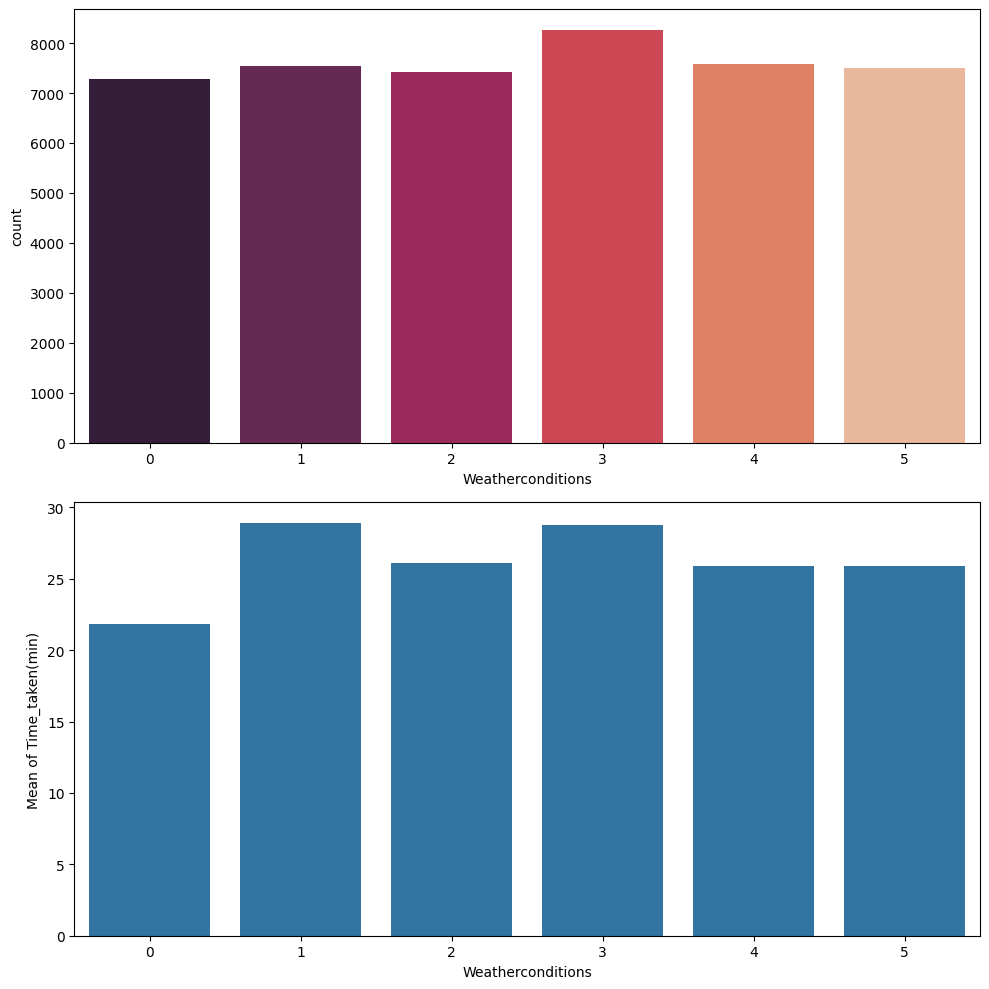

In [19]:
Weatherconditionsdf = train_df.groupby("Weatherconditions")["Time_taken(min)"].mean().to_frame().reset_index()
plt.figure(figsize=(12,6))
fig , ax = plt.subplots(2,1,figsize = (10,10))
ax1=sns.barplot(x=Weatherconditionsdf["Weatherconditions"],y=Weatherconditionsdf["Time_taken(min)"],ax=ax[1])
ax1.set_ylabel("Mean of Time_taken(min)")
ax2 = sns.countplot(x=train_df["Weatherconditions"],palette="rocket",ax=ax[0])
plt.tight_layout()

<Figure size 1200x600 with 0 Axes>

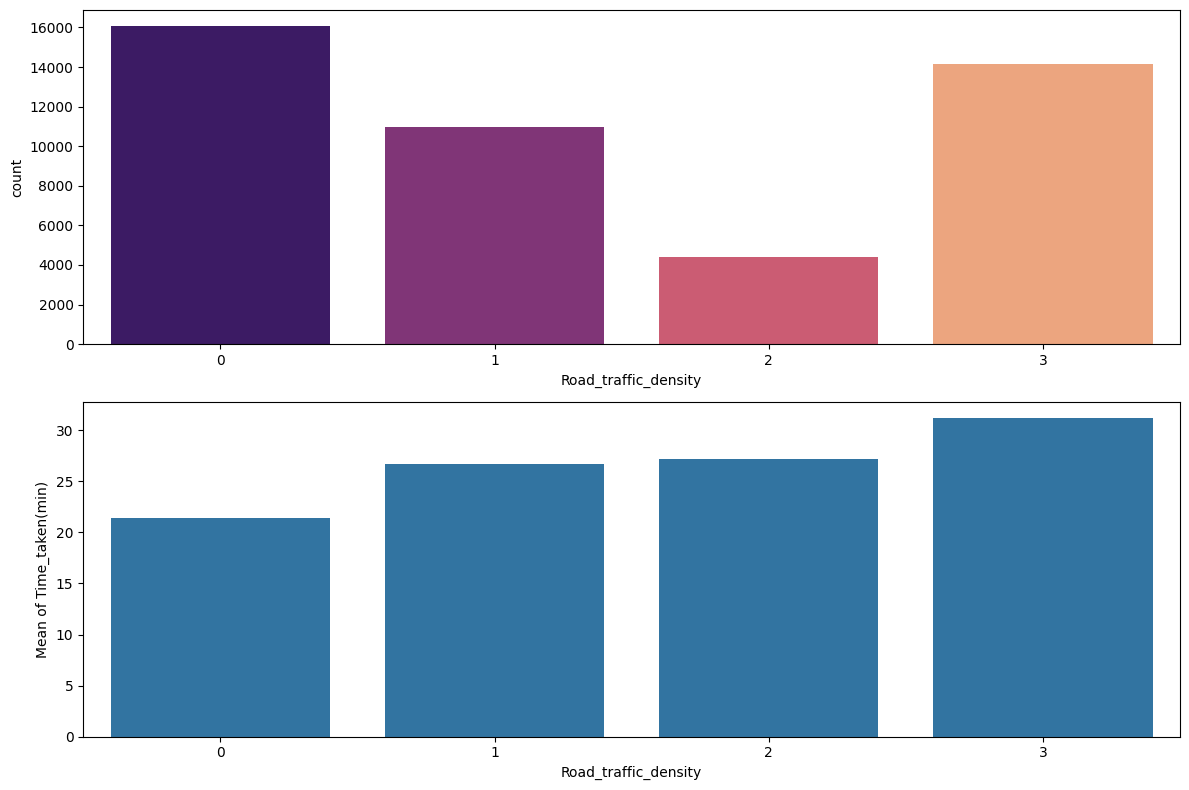

In [20]:
Road_traffic_densitydf = train_df.groupby("Road_traffic_density")["Time_taken(min)"].mean().to_frame().reset_index()
plt.figure(figsize=(12,6))
fig , ax = plt.subplots(2,1,figsize = (12,8))
ax1=sns.barplot(x=Road_traffic_densitydf["Road_traffic_density"],y=Road_traffic_densitydf["Time_taken(min)"],ax=ax[1])
ax1.set_ylabel("Mean of Time_taken(min)")
ax2 = sns.countplot(x=train_df["Road_traffic_density"],palette="magma",ax=ax[0])
plt.tight_layout()

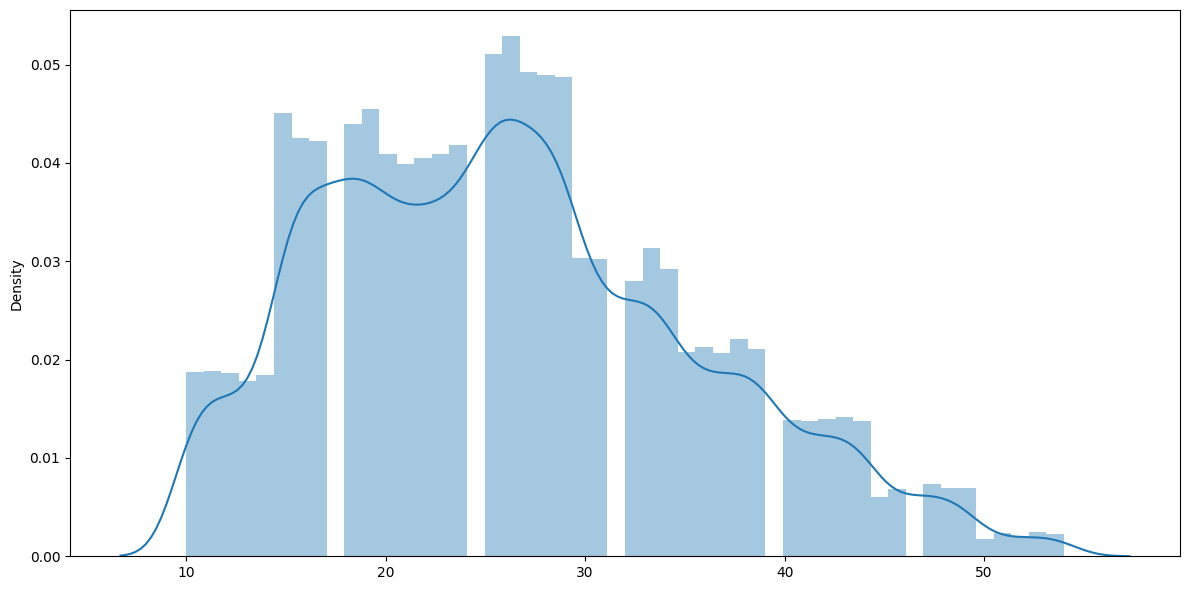

In [21]:
plt.figure(figsize=(12,6))
sns.distplot(x=train_df["Time_taken(min)"])
plt.tight_layout()

In [22]:
train_df.drop(["Order_Date"],axis=1,inplace=True)
test_df.drop(["Order_Date"],axis=1,inplace=True)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   Delivery_person_Ratings      45593 non-null  float64        
 1   Restaurant_latitude          45593 non-null  float64        
 2   Restaurant_longitude         45593 non-null  float64        
 3   Delivery_location_latitude   45593 non-null  float64        
 4   Delivery_location_longitude  45593 non-null  float64        
 5   Time_Orderd                  45593 non-null  object         
 6   Time_Order_picked            45593 non-null  timedelta64[ns]
 7   Weatherconditions            45593 non-null  int64          
 8   Road_traffic_density         45593 non-null  int64          
 9   Vehicle_condition            45593 non-null  int64          
 10  Type_of_vehicle              45593 non-null  int64          
 11  multiple_deliveries         

In [23]:
train_df.head(10)

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min)
0,4.9,22.745049,75.892471,22.765049,75.912471,11:30:00,0 days 11:45:00,0,2,2,0,0,24
1,4.5,12.913041,77.683237,13.043041,77.813237,19:45:00,0 days 19:50:00,4,3,2,1,1,33
2,4.4,12.914264,77.678400,12.924264,77.688400,08:30:00,0 days 08:45:00,5,0,0,0,1,26
3,4.7,11.003669,76.976494,11.053669,77.026494,18:00:00,0 days 18:10:00,0,1,0,0,1,21
4,4.6,12.972793,80.249982,13.012793,80.289982,13:30:00,0 days 13:45:00,1,2,1,1,1,30
5,4.8,17.431668,78.408321,17.461668,78.438321,21:20:00,0 days 21:30:00,1,3,0,0,1,26
6,4.7,23.369746,85.339820,23.479746,85.449820,19:15:00,0 days 19:30:00,3,3,1,1,1,40
7,4.6,12.352058,76.606650,12.482058,76.736650,17:25:00,0 days 17:30:00,1,1,2,0,1,32
8,4.8,17.433809,78.386744,17.563809,78.516744,20:55:00,0 days 21:05:00,4,3,0,0,1,34
9,4.2,30.327968,78.046106,30.397968,78.116106,21:55:00,0 days 22:10:00,3,3,2,0,3,46


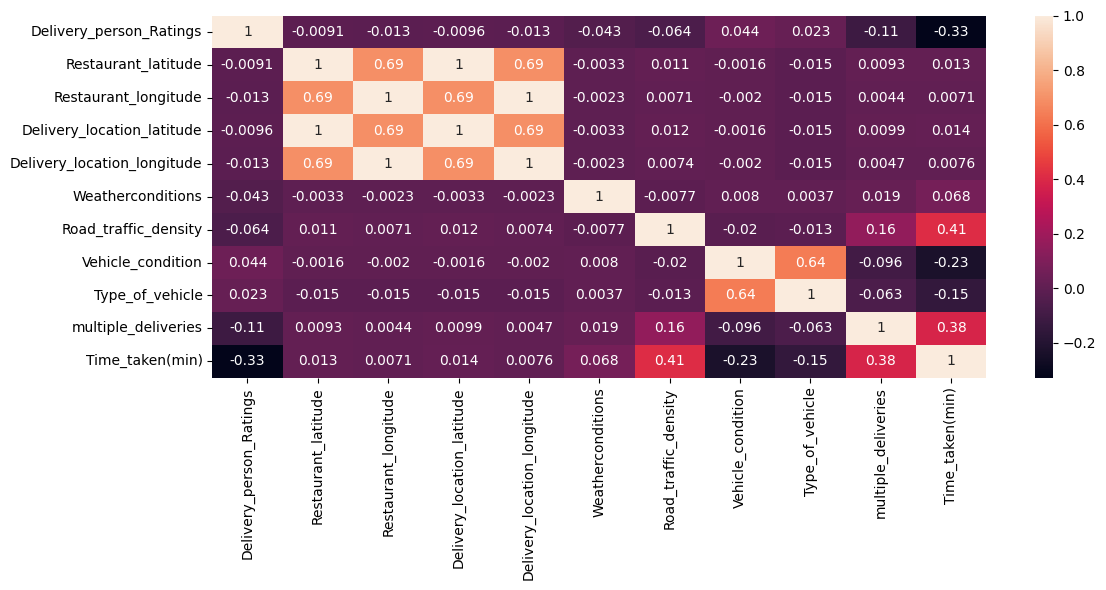

In [24]:
plt.figure(figsize=(12,6))
sns.heatmap(train_df.corr(numeric_only=True),annot=True)
plt.tight_layout()

In [25]:
train_df["Time_Order_picked"] = train_df["Time_Order_picked"].apply(lambda x: x.total_seconds())
test_df["Time_Order_picked"] = test_df["Time_Order_picked"].apply(lambda x: x.total_seconds())

In [26]:
train_df["Time_Orderd"] = pd.to_timedelta(train_df["Time_Orderd"])
train_df["Time_Orderd"] = train_df["Time_Orderd"].apply(lambda x: x.total_seconds())

test_df["Time_Orderd"] = pd.to_timedelta(test_df["Time_Orderd"])
test_df["Time_Orderd"] = test_df["Time_Orderd"].apply(lambda x: x.total_seconds())

In [27]:
############################################################################################################
# TODO: Calculate distance between restaurant location and Delivery location then drop the lat/lon columns #
############################################################################################################

# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


train_df['dist'] = \
    haversine(train_df['Restaurant_latitude'], train_df['Restaurant_longitude'],
              train_df['Delivery_location_latitude'], train_df['Delivery_location_longitude'])
test_df['dist'] = \
    haversine(test_df['Restaurant_latitude'], test_df['Restaurant_longitude'],
              test_df['Delivery_location_latitude'], test_df['Delivery_location_longitude'])

In [28]:
train_df.sort_values(by=['dist'], ascending=False).head()

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min),dist
15710,5.0,25.443994,81.860187,25.583994,82.000187,79800.0,80100.0,5,0,1,0,0,12,20.969489
25926,3.8,25.443994,81.860187,25.583994,82.000187,73500.0,73800.0,5,3,2,0,1,33,20.969489
912,4.7,25.443994,81.860187,25.583994,82.000187,82500.0,83400.0,1,0,2,2,0,26,20.969489
16640,4.8,25.449659,81.839744,25.589659,81.979744,79200.0,80100.0,0,3,1,1,0,20,20.969045
25476,4.7,25.449659,81.839744,25.589659,81.979744,76200.0,76500.0,2,3,1,1,0,18,20.969045


In [29]:
train_df.sort_values(by=['dist'], ascending=True).head()

,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_vehicle,multiple_deliveries,Time_taken(min),dist
26585,4.5,30.914057,75.839820,30.924057,75.849820,33000.0,33600.0,2,0,2,2,1,13,1.465067
7410,4.8,30.914057,75.839820,30.924057,75.849820,40500.0,40800.0,4,2,2,1,1,16,1.465067
33066,4.9,30.914057,75.839820,30.924057,75.849820,39000.0,39900.0,1,0,0,0,1,16,1.465067
28262,4.8,30.905562,75.832841,30.915562,75.842841,42000.0,42300.0,5,2,2,2,1,26,1.465123
18399,4.7,30.905562,75.832841,30.915562,75.842841,31500.0,31800.0,0,0,2,1,1,21,1.465123


In [30]:
train_df.drop(columns=['Time_Order_picked','Time_Orderd', 'Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'
], axis=1, inplace=True)
test_df.drop(columns=['Time_Order_picked','Time_Orderd', 'Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude'
], axis=1, inplace=True)

In [31]:
train_df['dist'].sort_values()

q_low = train_df["dist"].quantile(0.01)
q_hi  = train_df["dist"].quantile(0.99)

df_filtered = train_df #[(train_df["dist"] < q_hi) & (train_df["dist"] > q_low)]
df_filtered.drop_duplicates(inplace=True)

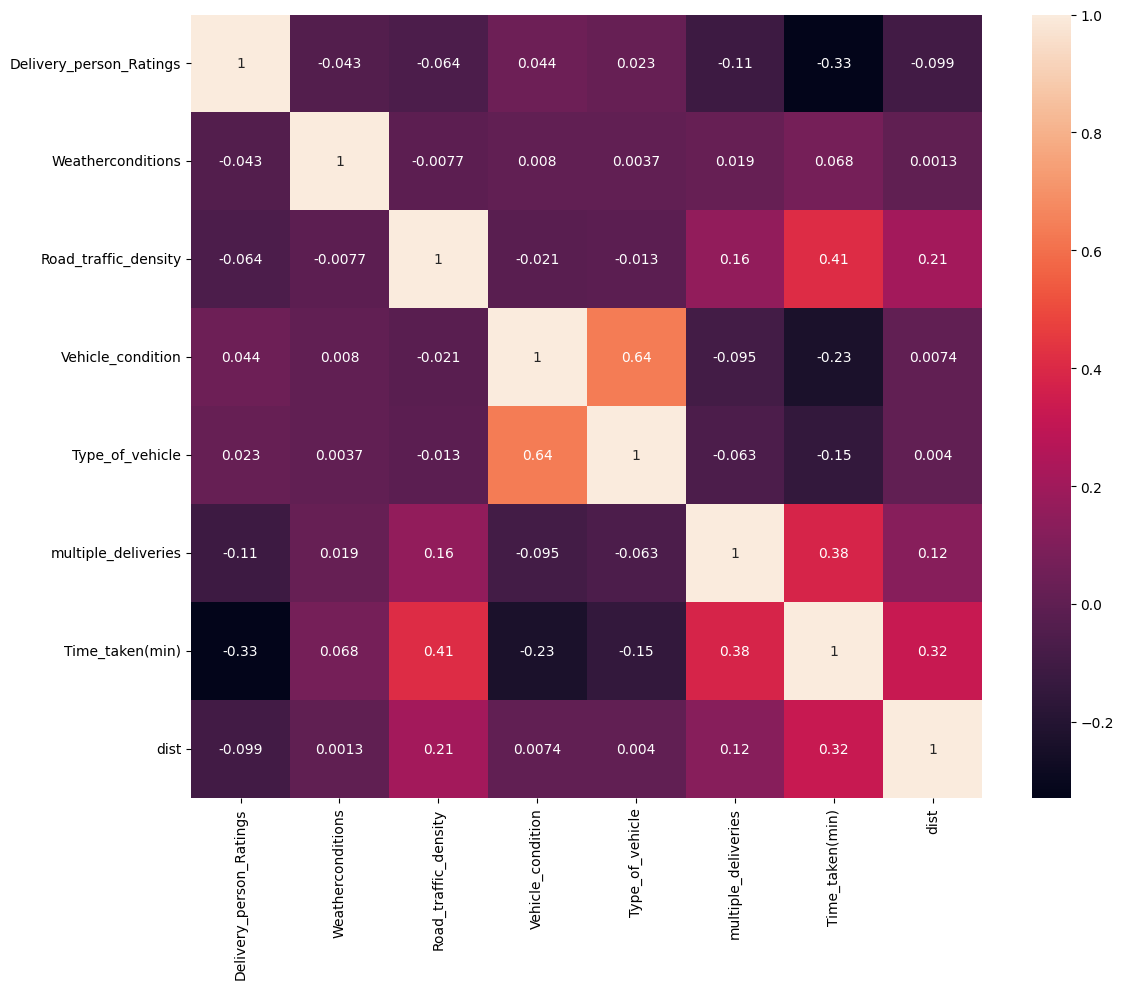

In [32]:
plt.figure(figsize=(12,10))
sns.heatmap(df_filtered.corr(), annot=True)
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

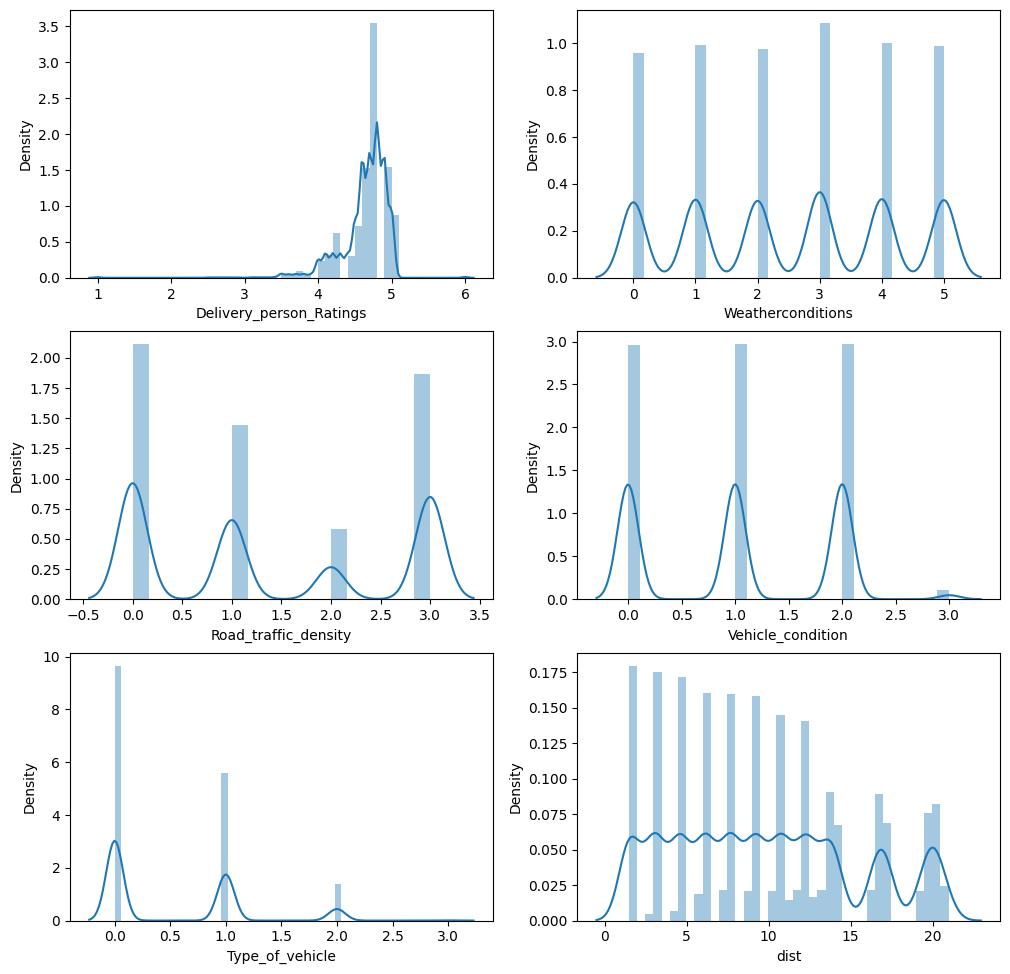

In [33]:
num_list=[i for i in df_filtered.select_dtypes(["int64","float64"])]
cat_list=[i for i in df_filtered.select_dtypes("object")]

k=1
plt.tight_layout()
plt.figure(figsize=(12,16))

for i in df_filtered.loc[:,num_list]:
    plt.subplot(4,2,k)
    sns.distplot(df_filtered[i])
    k+=1

Text(0.5, 1.0, 'Histogram of Distance Distribution')

<Figure size 640x480 with 0 Axes>

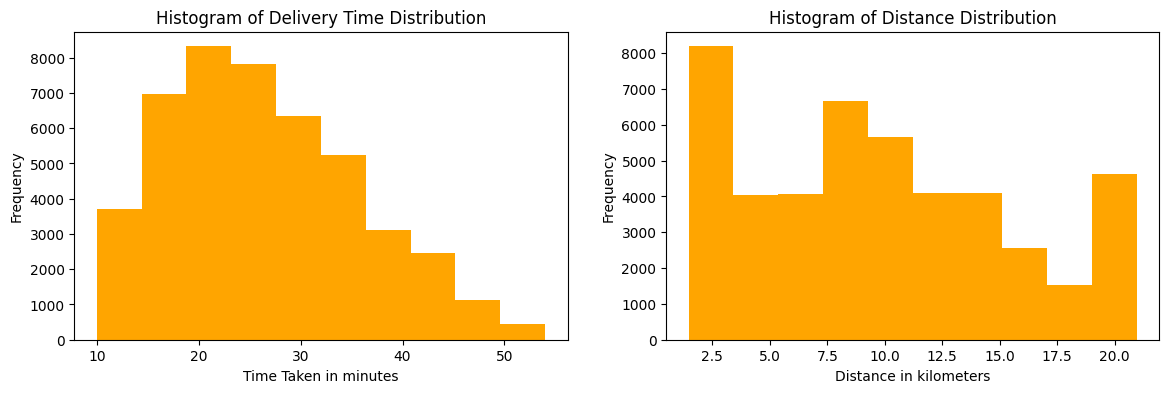

In [34]:
#sns.lineplot(x=df_filtered.dist,y=df_filtered["Time_taken(min)"],data=df_filtered)

plt.tight_layout()
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.hist(df_filtered['Time_taken(min)'],color = 'Orange')
plt.xlabel('Time Taken in minutes')
plt.ylabel('Frequency')
plt.title("Histogram of Delivery Time Distribution")


# fig, ax= plt.subplots()

plt.subplot(1,2,2)
plt.hist(df_filtered['dist'],color = 'Orange')
plt.xlabel('Distance in kilometers')
plt.ylabel('Frequency')
plt.title("Histogram of Distance Distribution")


<Axes: xlabel='Time Taken (min)', ylabel='Distance (km)'>

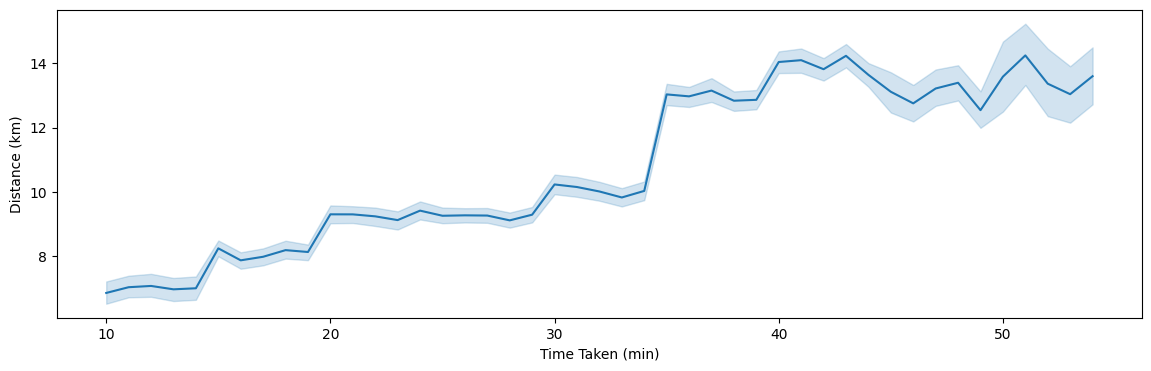

In [35]:
fig,axes = plt.subplots(1,1, figsize=(14,4))
plt.xlabel('Time Taken (min)')
plt.ylabel('Distance (km)')
sns.lineplot(x = df_filtered["Time_taken(min)"], y = df_filtered['dist'], data = df_filtered)

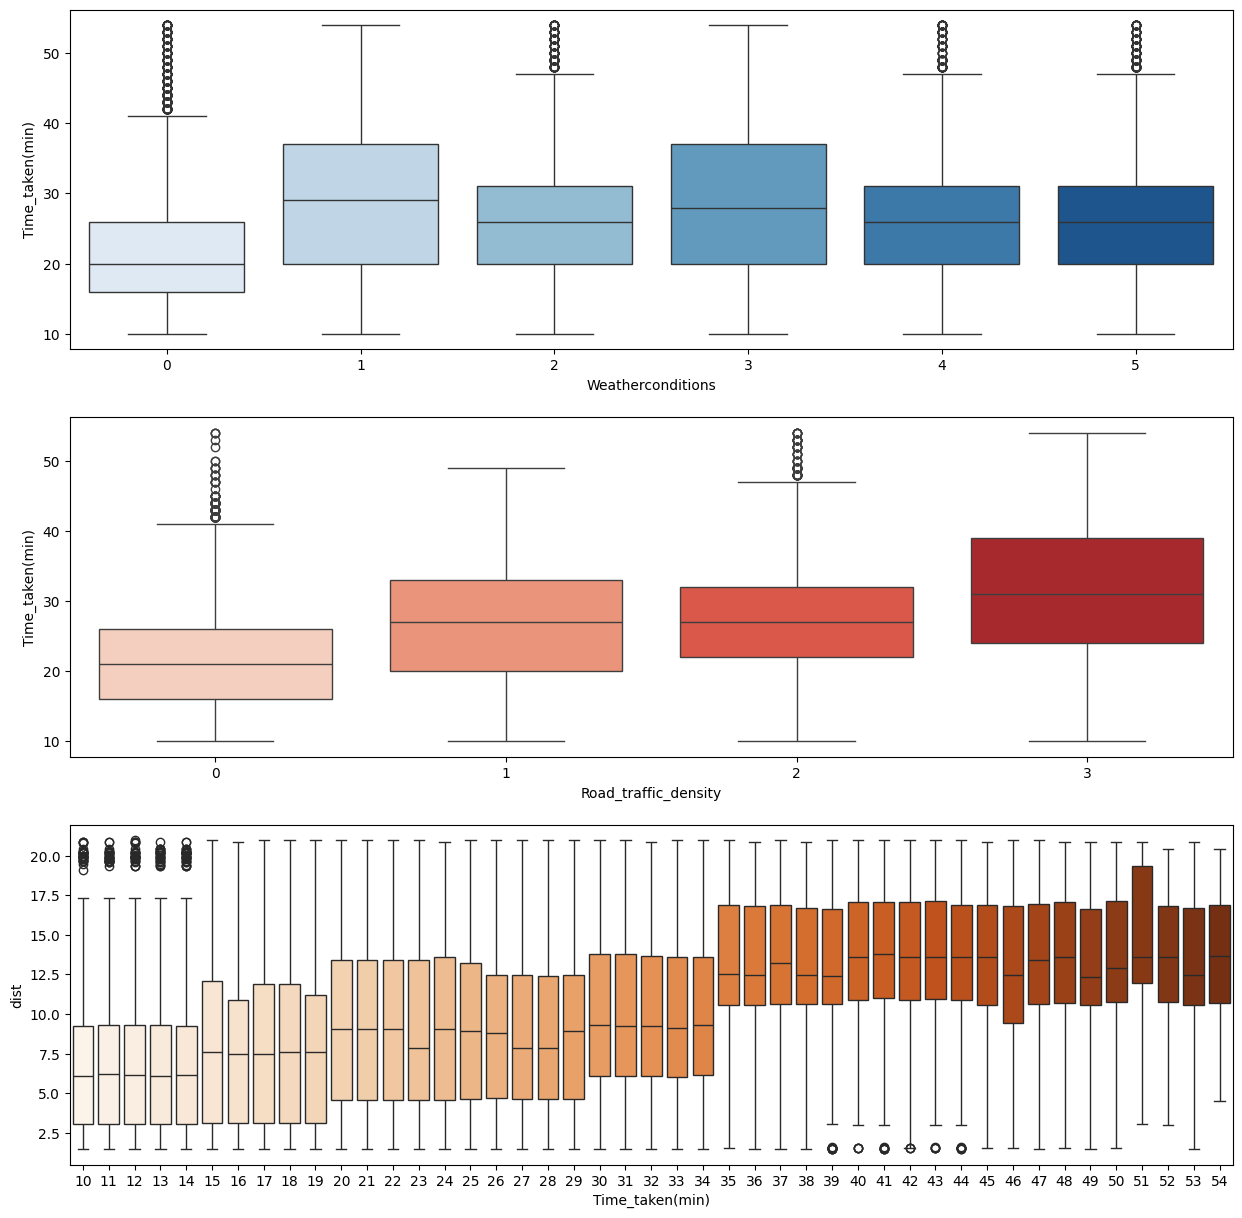

In [36]:
fig,axes = plt.subplots(3,1, figsize=(15,15))

sns.boxplot(data=df_filtered,x = 'Weatherconditions', y ='Time_taken(min)', ax=axes[0], palette="Blues")
sns.boxplot(data=df_filtered,x ='Road_traffic_density', y='Time_taken(min)', ax=axes[1], palette="Reds")
sns.boxplot(data=df_filtered,x='Time_taken(min)', y ='dist', ax=axes[2], palette="Oranges")

fig.show()

In [37]:
df_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
Delivery_person_Ratings,45525.0,4.640688,0.329412,1.000000,4.600000,4.700000,4.800000,6.000000
Weatherconditions,45525.0,2.522570,1.690591,0.000000,1.000000,3.000000,4.000000,5.000000
Road_traffic_density,45525.0,1.365777,1.247976,0.000000,0.000000,1.000000,3.000000,3.000000
Vehicle_condition,45525.0,1.023921,0.839022,0.000000,0.000000,1.000000,2.000000,3.000000
Type_of_vehicle,45525.0,0.507062,0.653019,0.000000,0.000000,0.000000,1.000000,3.000000
multiple_deliveries,45525.0,0.750115,0.567655,0.000000,0.000000,1.000000,1.000000,3.000000
Time_taken(min),45525.0,26.297529,9.386383,10.000000,19.000000,26.000000,32.000000,54.000000
dist,45525.0,9.739969,5.607278,1.465067,4.663419,9.220209,13.681492,20.969489


In [38]:
print("Training Columns: ", train_df.columns)

Training Columns:  Index(['Delivery_person_Ratings', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_vehicle', 'multiple_deliveries',
       'Time_taken(min)', 'dist'],
      dtype='object')


In [39]:
X = train_df.drop("Time_taken(min)",axis=1)
Y = train_df["Time_taken(min)"]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [40]:
def RSE(y_true, y_predicted):
    y_true = np.array(y_true)
    y_predicted = np.array(y_predicted)
    RSS = np.sum(np.square(y_true - y_predicted))

    rse = sqrt(RSS / (len(y_true) - 2))
    return rse

In [41]:
#models=[LinearRegression(),RandomForestRegressor(n_estimators=42,n_jobs=-1),AdaBoostRegressor(),KNeighborsRegressor(),DecisionTreeRegressor(),GradientBoostingRegressor(),XGBRegressor(),LGBMRegressor()]
#model_names=["LinearRegression","RandomForestRegressor","AdaBoostRegressor","KNeighborsRegressor","DecisionTreeRegressor","GradientBoostingRegressor","XGBRegressor","LGBMRegressor"]

models=[LinearRegression(),RandomForestRegressor(n_estimators=42,n_jobs=-1),GradientBoostingRegressor(),LGBMRegressor()]
model_names=["LinearRegression","RandomForestRegressor","GradientBoostingRegressor","LGBMRegressor"]

MSE=[]
r_2=[]
RSE_ = []
accuracy = []
RMSE = []

for model in range (len(models)):
    model=models[model]
    model.fit(X_train,y_train)
    y_pre=model.predict(X_test)
    MSE.append(round(mean_squared_error(y_true=y_test,y_pred=y_pre),5))
    r_2.append(r2_score(y_true=y_test,y_pred=y_pre))
    RSE_.append(round(RSE(y_test,y_pre),5))
    accuracy.append((model.score(X_test,y_test))*100)
    RMSE.append(sqrt(mean_squared_error(y_true=y_test,y_pred=y_pre)))
d=pd.DataFrame({'Modelling Name':model_names,'MSE':MSE,"R_2":r_2,"RSE":RSE_,"Accuracy":accuracy,"RMSE":RMSE})
d

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 306
[LightGBM] [Info] Number of data points in the train set: 31867, number of used features: 7
[LightGBM] [Info] Start training from score 26.286189


,Modelling Name,MSE,R_2,RSE,Accuracy,RMSE
0,LinearRegression,51.48602,0.419941,7.17590,41.994084,7.175376
1,RandomForestRegressor,31.10208,0.649593,5.57733,64.959326,5.576924
2,GradientBoostingRegressor,29.57091,0.666844,5.43831,66.684404,5.437914
3,LGBMRegressor,25.59143,0.711678,5.05917,71.167816,5.058797


In [42]:
cdf = pd.DataFrame(models[0].coef_, X.columns, columns=['Coeff'])
cdf

,Coeff
Delivery_person_Ratings,-7.102214
Weatherconditions,0.307586
Road_traffic_density,2.299743
Vehicle_condition,-2.130569
Type_of_vehicle,-0.059305
multiple_deliveries,4.340614
dist,0.335593


In [43]:
test_df.isna().sum()

Delivery_person_Ratings    0
Weatherconditions          0
Road_traffic_density       0
Vehicle_condition          0
Type_of_vehicle            0
multiple_deliveries        0
dist                       0
dtype: int64

In [44]:
predictions = models[3].predict(X_test)
predictions

array([38.35527203, 21.15816026, 24.63342056, ..., 15.76911075,
       31.30702636, 31.97226958])

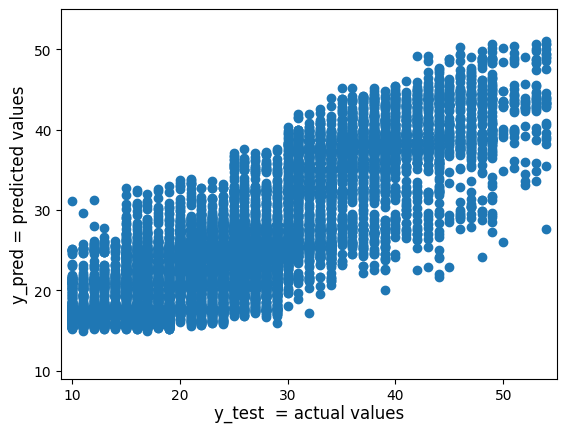

In [45]:
fig, ax = plt.subplots()

x_min, x_max = 9.0, 55.0
y_min, y_max = 9.0, 55.0
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)

ax.set_xlabel('y_test  = actual values', fontsize=12, labelpad=1)
ax.set_ylabel('y_pred = predicted values', fontsize=12)
plt.scatter(y_test, predictions)


<Axes: xlabel='Time_taken(min)', ylabel='Density'>

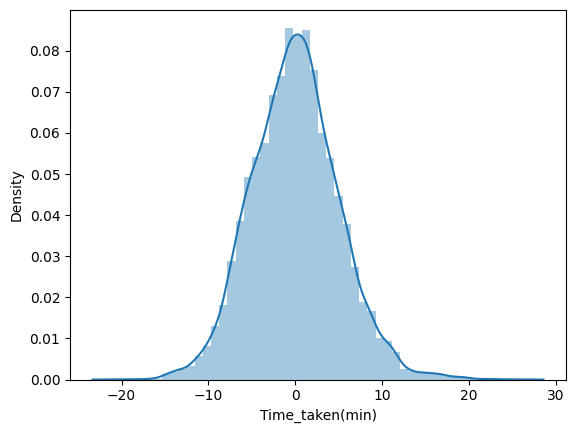

In [46]:
sns.distplot((y_test-predictions))

In [47]:
from ipywidgets import widgets

person_rating = widgets.Dropdown(
    options=[('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6)],
    value=5,
    description='Driver Rating:',
    style= {'description_width': '100px'}
)
weather_cond = widgets.Dropdown(
    options=[('Sunny', 0), ('Cloudy', 1), ('Windy', 2), ('Fog', 3), ('Stormy', 4), ('Sandstorm', 5)],
    value=0,
    description='Weather:',
    style= {'description_width': '100px'}
)
traffic = widgets.FloatSlider(description='Traffic Density:', min=0, max=3, step=1, style= {'description_width': '100px'})
distance = widgets.FloatSlider(description='Distance:', min=1.0, max=20.0, step=0.1, style= {'description_width': '100px'})

#A button for the user to get predictions using input valus. 
button_predict = widgets.Button( description='Predict Delivery Time' )
button_ouput = widgets.Label(value='Enter values and press the \"Predict\" button.' )

#Defines what happens when you click the button 
def on_click_predict(b):
    data = {
        "Delivery_person_Ratings": [person_rating.value],
        "Weatherconditions": [weather_cond.value],
        "Road_traffic_density": [traffic.value],
        "Vehicle_condition": [1],
        "Type_of_vehicle": [1],
        "dist": [distance.value]
    }
    udf = pd.DataFrame(data)
    pred = models[3].predict(udf)
    button_ouput.value='Predicted Delivery Time (minutes) = ' + str(pred[0]-10)

button_predict.on_click(on_click_predict)

#Displays the text boxes and button inside a VBox 
vb=widgets.VBox([person_rating, weather_cond, traffic, distance, button_predict, button_ouput])
print('\033[1m' + 'Enter parameters and make a prediction:' + '\033[0m')
display(vb)


Enter parameters and make a prediction:


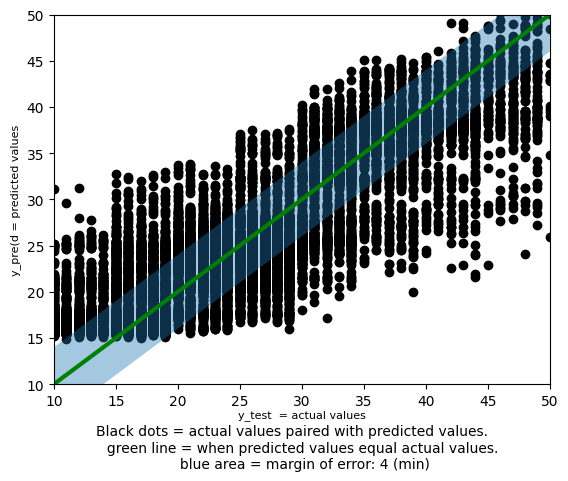

In [48]:
fig, ax = plt.subplots()
x_min, x_max = 10.0, 50.0
y_min, y_max = 10.0, 50.0
m = 4 # margin of error
x = np.linspace(x_min, x_max, 50)
ax.set_ylim(y_min, y_max)
ax.set_xlim(x_min, x_max)

plt.plot(x, x, 'g', linewidth=3)
plt.scatter(y_test, predictions, color="black")
ax.fill_between(x, x - m, x + m, alpha=0.4)

ax.set_xlabel('y_test  = actual values', fontsize=8, labelpad=1)
ax.set_ylabel('y_pre(d = predicted values', fontsize=8)
plt.figtext(0.5, -0.06, "Black dots = actual values paired with predicted values. \n \
    green line = when predicted values equal actual values. \n \
    blue area = margin of error: 4 (min)", wrap=True, horizontalalignment='center' );